In [3]:
import pandas as pd
import numpy as np

%matplotlib inline

### Boston Public Library Electricity Consumption

For the independent practice, we will analyze the electrical consuption data from Boston Public Library sampled every 5 min over a two year period from 2016 to 2017.

The data is again separated by date stamp, but we will focus on analyzing averaged KW sampled on an hourly basis for simplicity.



#### Loading the data and setting the DateTimeIndex

In [4]:
dataBPL = pd.read_csv('https://data.boston.gov/dataset/652762e9-2556-47cd-8e80-798546992a57/resource/87c759ee-63b9-4aec-a00b-bba1672a20ef/download/tmpa1bav9m_.csv', skipinitialspace=True,
                   low_memory=False)

In [5]:
dataBPL['Date'] = pd.to_datetime(dataBPL['DateTime_Measured'])
dataBPL.set_index('Date', inplace=True)

dataBPL['Year'] = dataBPL.index.year
dataBPL['Month'] = dataBPL.index.month
dataBPL['Day']= dataBPL.index.day
dataBPL['Weekday']= dataBPL.index.weekday
dataBPL['Hour']= dataBPL.index.hour
dataBPL['Time'] = dataBPL.index.time

####  Data Evaluation
- The `rolling_mean` is taken for every 12 time points which corresponds to 1 hour to smooth out the noise. The smoothed average data is averaged, resampled every hour and plotted in the first plot.
- Seasonal differencing The sampled rolling mean data difference is calculated by subtracting data from previous time point.

In [86]:
BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 6).resample('H').mean()
BPL_diff8760=BPL_electric.diff(periods=8760)
BPL_diff24=BPL_electric.diff(periods=24)
BPL_diff=BPL_electric.diff() 

/home/marc/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=6,center=False).mean()
  """Entry point for launching an IPython kernel.


In [87]:
BPL_electric=BPL_electric.dropna(axis=0, how='any')
BPL_diff=BPL_diff.dropna(axis=0, how='any')
BPL_diff24=BPL_diff24.dropna(axis=0, how='any')
BPL_diff8760=BPL_diff8760.dropna(axis=0, how='any')

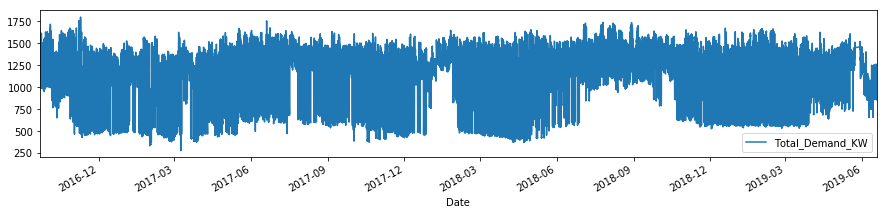

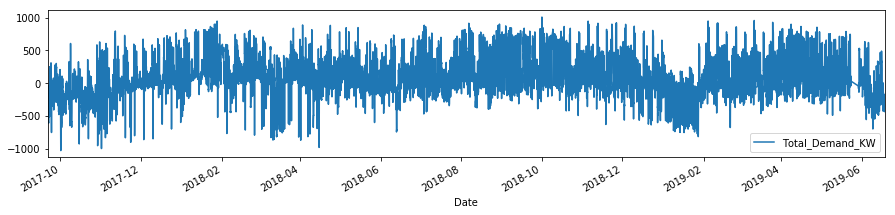

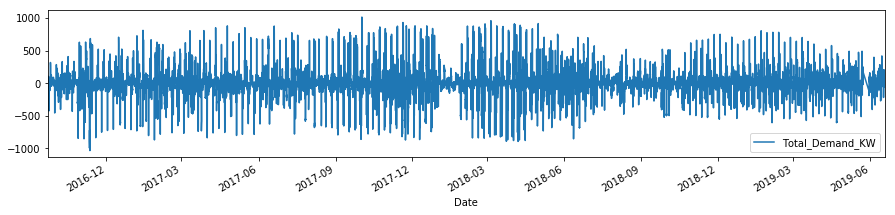

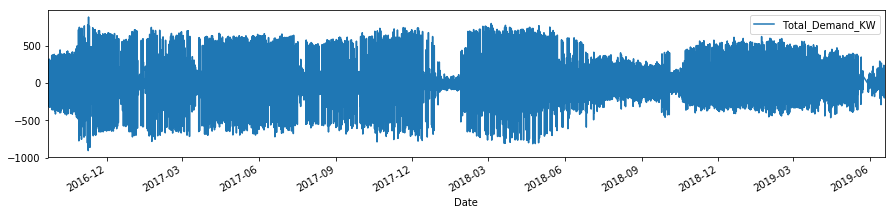

In [88]:
BPL_electric.plot(figsize=(15,3))
BPL_diff8760.plot(figsize=(15,3))
BPL_diff24.plot(figsize=(15,3))
BPL_diff.plot(figsize=(15,3))

In [89]:
print('Autocorrelation base: ', BPL_electric['Total_Demand_KW'].autocorr(24))
print('Autocorrelation 1: ', BPL_diff['Total_Demand_KW'].autocorr(24))
print('Autocorrelation 7: ', BPL_diff24['Total_Demand_KW'].autocorr(24))

('Autocorrelation base: ', 0.85563081259375584)
('Autocorrelation 1: ', 0.76044855265488753)
('Autocorrelation 7: ', -0.30132786179250737)


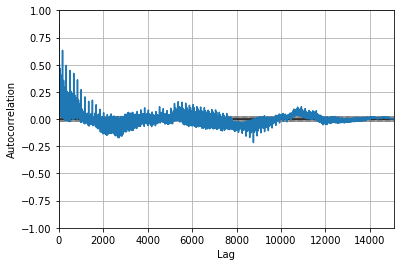

In [90]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(BPL_diff8760['Total_Demand_KW'])

####  Statistical hypothesis tests of stationarity that are designed for determining whether differencing is required
- KPSS tests the null hypothesis that the data are stationary. Test for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) suggest that differencing is required

In [91]:
from pandas import Series
from statsmodels.tsa.stattools import kpss
result = kpss(BPL_electric['Total_Demand_KW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 7.079330
p-value: 0.010000
Critical Values:
	5%: 0.463
	1%: 0.739
	2.5%: 0.574
	10%: 0.347


KPSS tests on the base data has a p-value 0.01 < .05 so the null hypothesis that the data is stationary is not the case and that differencing should be applied. Seasonality is likely due to increased energy consumption during summer and possibly winter. Data is resampled hourly and a one year time period in hours is 8760 hours. Differencing yearly results in KPSS of

In [92]:
result = kpss(BPL_diff8760['Total_Demand_KW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.207611
p-value: 0.010000
Critical Values:
	5%: 0.463
	1%: 0.739
	2.5%: 0.574
	10%: 0.347


A p-value of 0.01 for the data differenced by a year indicates no yearly seasonality.
Differencing data daily results in a KPSS of

In [93]:
result = kpss(BPL_diff24['Total_Demand_KW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.008411
p-value: 0.100000
Critical Values:
	5%: 0.463
	1%: 0.739
	2.5%: 0.574
	10%: 0.347


A p-value of 0.1 for the data differenced by a day indicates mild yearly seasonality.
Differencing data daily results in a KPSS of

In [95]:
result = kpss(BPL_diff['Total_Demand_KW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.010710
p-value: 0.100000
Critical Values:
	5%: 0.463
	1%: 0.739
	2.5%: 0.574
	10%: 0.347


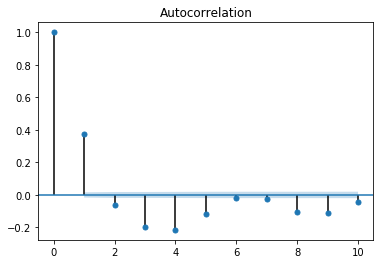

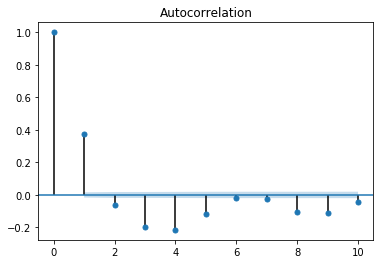

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(BPL_diff['Total_Demand_KW'], lags=10)

# The dataBPL dataset is sampled every 5 minutes and show correlation peaks every 
# 7 day (2016 data points) cycles and subpeaks every 24 hours. The correlation 
# factor is 0.8 at 168 hours (weekly) 

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

In [67]:
test={'1%':10, '2%':20,'10%':100,'50%':500,'70%':700}
for key, value in test.items():
	print('\t%s: %.3f' % (key, value))

	70%: 700.000
	2%: 20.000
	50%: 500.000
	1%: 10.000
	10%: 100.000


#### Compute the 1, 24, 168 autocorrelations for Boston Public Library Hourly_KW and autocorrelation plot.

In [36]:
print('Autocorrelation 1: ', BPL_electric['Total_Demand_KW'].autocorr(1))
print('Autocorrelation 7: ', BPL_electric['Total_Demand_KW'].autocorr(24))
print('Autocorrelation 168: ', BPL_electric['Total_Demand_KW'].autocorr(168))

('Autocorrelation 1: ', 0.97504664394600282)
('Autocorrelation 7: ', 0.86055668576508482)
('Autocorrelation 168: ', 0.84521731875316286)


In [37]:
print('Autocorrelation 1: ', DIFF['Total_Demand_KW'].autocorr(1))
print('Autocorrelation 7: ', DIFF['Total_Demand_KW'].autocorr(24))
print('Autocorrelation 168: ', DIFF['Total_Demand_KW'].autocorr(168))

('Autocorrelation 1: ', 0.9820380482222234)
('Autocorrelation 7: ', 0.78008010300683384)
('Autocorrelation 168: ', 0.69299555293028692)


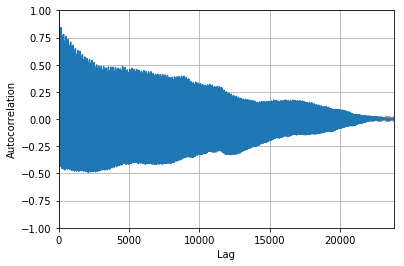

In [38]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(CH_electric['Total_Demand_KW'])
autocorrelation_plot(BPL_electric['Total_Demand_KW'])
#autocorrelation_plot(DIFF['Total_Demand_KW'])

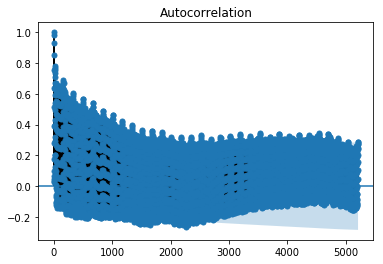

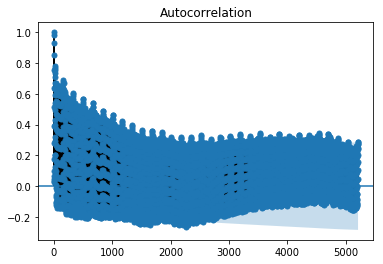

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(DIFF['Total_Demand_KW'], lags=5209)

# The dataBPL dataset is sampled every 5 minutes and show correlation peaks every 
# 7 day (2016 data points) cycles and subpeaks every 24 hours. The correlation 
# factor is 0.8 at 168 hours (weekly) 

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

In [11]:
BPL_electric.tail()

,Total_Demand_KW
Date,
2018-09-15,1379.608796
2018-09-16,1363.241898
2018-09-17,1421.337963
2018-09-18,1407.743056
2018-09-19,1264.996633


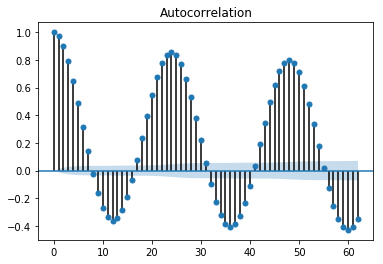

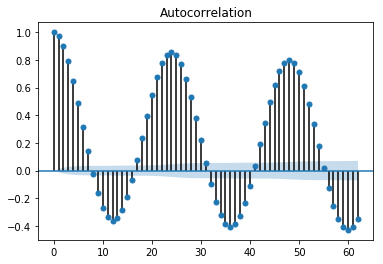

In [42]:

plot_acf(BPL_electric['Total_Demand_KW'], lags=62)

##### Split the energy consumption (5 min) data in a training and test set - using 75% of the data for training

In [13]:
n = len(dataBPL.Total_Demand_KW)

train = dataBPL.Total_Demand_KW[:int(.75*n)]
test = dataBPL.Total_Demand_KW[int(.75*n):]

In [14]:
train.head()

Date
2018-09-19 08:20:00    1224.0
2018-09-19 08:15:00    1231.0
2018-09-19 08:10:00    1224.0
2018-09-19 08:05:00    1231.0
2018-09-19 08:00:00    1180.0
Name: Total_Demand_KW, dtype: float64

In [15]:
train.tail()

Date
2017-03-22 08:45:00    1389.6
2017-03-22 08:40:00    1317.6
2017-03-22 08:35:00    1346.4
2017-03-22 08:30:00    1389.6
2017-03-22 08:25:00    1353.6
Name: Total_Demand_KW, dtype: float64

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [17]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [19]:
model = sm.tsa.ARIMA(train, (5, 1, 0)).fit()
print(model.params)

const                      0.000825
ar.L1.D.Total_Demand_KW    0.078804
ar.L2.D.Total_Demand_KW    0.034944
ar.L3.D.Total_Demand_KW    0.046253
ar.L4.D.Total_Demand_KW    0.044194
ar.L5.D.Total_Demand_KW    0.015254
dtype: float64


In [20]:
test.shape

(52407,)

In [21]:
train.shape

(157221,)

In [23]:
predictions = model.predict(dynamic=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:               157220
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -820856.746
Method:                       css-mle   S.D. of innovations             44.797
Date:                Wed, 12 Jun 2019   AIC                        1641727.491
Time:                        12:32:29   BIC                        1641797.249
Sample:                    09-19-2018   HQIC                       1641748.240
                         - 03-22-2017                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0008      0.145      0.006      0.995      -0.283       0.285
ar.L1.D.Total_Demand_KW     0.0788      0.003     31.250      0.000       0.074       0.084
ar.L2.D.Total_Demand_KW     0.0349      0.003     13.828      0.000       0.030       0.040
ar.L3.D.Total_Demand_KW     0.0463      0.003     18.311      0.000       0.041       0.051
ar.L4.D.Total_Demand_KW     0.0442      0.003     17.488      0.000       0.039       0.049
ar.L5.D.Total_Demand_KW     0.0153      0.003      6.049      0.000       0.010       0.020
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6768           -0.0000j            1.6768           -0.0000
AR.2            0.2258           -2.1709j            2.1826           -0.2335
AR.3            0.2258           +2.1709j            2.1826            0.2335
AR.4           -2.5127           -1.3759j            2.8647           -0.4203
AR.5           -2.5127           +1.3759j            2.8647            0.4203
-----------------------------------------------------------------------------
"""

In [25]:
model = sm.tsa.ARIMA(train, (1, 1, 0)).fit()

predictions = model.predict(dynamic=True)
#predictions = model.predict(
#    '2016-12-31 17:10:00',
#    '2017-10-31 08:10:00',
#    dynamic=True, 
#)
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

ValueError: Found input variables with inconsistent numbers of samples: [52407, 157219]

#### Plot the residuals - where are their significant errors.

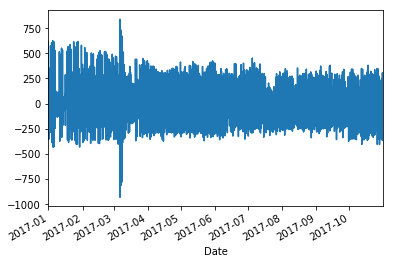

In [46]:
model.resid.plot()

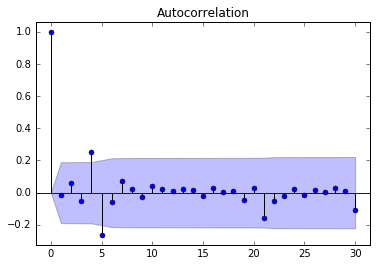

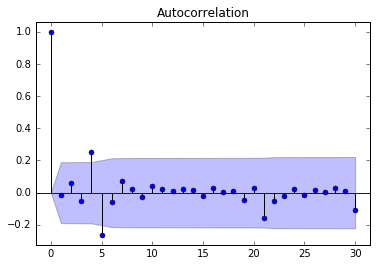

In [15]:
plot_acf(model.resid, lags=30)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [16]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.240909485947)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Tue, 08 Mar 2016   AIC                           2876.963
Time:                        12:48:22   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003         0.108     0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548        -0.132     0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3081           +0.0000j            2.3081            0.0000
AR.2           -7.3588           +0.0000j            7.3588            0.5000
-----------------------------------------------------------------------------
"""

In [17]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80502.745386798299)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144113.350
Date:                Tue, 08 Mar 2016   AIC                           2863.563
Time:                        12:48:23   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.327      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0400      0.090    -11.583      0.000        -1.216    -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.381      0.000        -0.641    -0.299
ma.L1.Weekly_Sales     1.4692      0.058     25.424      0.000         1.356     1.582
ma.L2.Weekly_Sales     0.9998      0.074     13.576      0.000         0.855     1.144
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9507j            1.4584           -0.3870
AR.2           -1.1060           +0.9507j            1.4584            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [18]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 77789.494825392394)


/Users/arahuja/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.622
Method:                       css-mle   S.D. of innovations         142943.992
Date:                Tue, 08 Mar 2016   AIC                           2841.243
Time:                        12:48:27   BIC                           2859.887
Sample:                    02-14-2010   HQIC                          2848.800
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  577.5354    622.025      0.928      0.355      -641.611  1796.682
ar.L1.D.Weekly_Sales    -1.0481      0.090    -11.609      0.000        -1.225    -0.871
ar.L2.D.Weekly_Sales    -0.4778      0.088     -5.442      0.000        -0.650    -0.306
ma.L1.D.Weekly_Sales     0.4694      0.116      4.057      0.000         0.243     0.696
ma.L2.D.Weekly_Sales    -0.4693      0.152     -3.095      0.003        -0.766    -0.172
ma.L3.D.Weekly_Sales    -0.9997      0.123     -8.098      0.000        -1.242    -0.758
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0967           -0.9434j            1.4466           -0.3869
AR.2           -1.0967           +0.9434j            1.4466            0.3869
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7348           -0.6784j            1.0001           -0.3813
MA.3           -0.7348           +0.6784j            1.0001            0.3813
-----------------------------------------------------------------------------
"""